In [1]:
# A1, A2, A3
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression

# A1. Loading Dataset
df = pd.read_csv("./fifa_legacy.csv", low_memory=False)
print("Size of dataset:", df.shape)
print(df.head(3)) # checking


Size of dataset: (161583, 110)
   player_id                                        player_url  fifa_version  \
0     158023                /player/158023/lionel-messi/150002            15   
1      20801  /player/20801/c-ronaldo-dos-santos-aveiro/150002            15   
2       9014                  /player/9014/arjen-robben/150002            15   

   fifa_update fifa_update_date         short_name  \
0            2       2014-09-18           L. Messi   
1            2       2014-09-18  Cristiano Ronaldo   
2            2       2014-09-18          A. Robben   

                             long_name player_positions  overall  potential  \
0       Lionel Andrés Messi Cuccittini               CF       93         95   
1  Cristiano Ronaldo dos Santos Aveiro           LW, LM       92         92   
2                         Arjen Robben       RM, LM, RW       90         90   

   ...   cdm   rdm   rwb    lb   lcb    cb   rcb    rb    gk  \
0  ...  62+3  62+3  62+3  54+3  45+3  45+3  45+3  

In [6]:
# A1. Data Types & Attributes
print("\n===A1. Data Types & Attributes ===")

attributes = {
    "player_id": "Discrete - Unique identifier (integer, no scale or order, just IDs).",
    "short_name": "Nominal - Player’s name (categorical label, no inherent order).",
    "age": "Discrete - Player age in years (whole numbers only, countable).",
    "height_cm": "Continuous - Player height in cm (measured on ratio scale, allows decimals).",
    "weight_kg": "Continuous - Player weight in kg (measured on ratio scale, allows decimals).",
    "overall": "Ordinal - Skill rating (ordered levels, but intervals not guaranteed equal).",
    "wage_eur": "Continuous - Player’s wage in euros (ratio scale, can take any non-negative value).",
    "preferred_foot": "Nominal - Footedness (categorical: left/right, no ranking).",
    "work_rate": "Ordinal - Work rate categories (e.g., Low/Medium/High, ordered but not numeric)."
}

print("\Sample of classy-attributes:")
for col, desc in attributes.items():
    if col in df.columns:
        print(f"{col}: {desc}")


===A1. Data Types & Attributes ===
\Sample of classy-attributes:
player_id: Discrete - Unique identifier (integer, no scale or order, just IDs).
short_name: Nominal - Player’s name (categorical label, no inherent order).
age: Discrete - Player age in years (whole numbers only, countable).
height_cm: Continuous - Player height in cm (measured on ratio scale, allows decimals).
weight_kg: Continuous - Player weight in kg (measured on ratio scale, allows decimals).
overall: Ordinal - Skill rating (ordered levels, but intervals not guaranteed equal).
wage_eur: Continuous - Player’s wage in euros (ratio scale, can take any non-negative value).
preferred_foot: Nominal - Footedness (categorical: left/right, no ranking).
work_rate: Ordinal - Work rate categories (e.g., Low/Medium/High, ordered but not numeric).


<>:16: SyntaxWarning: invalid escape sequence '\S'
<>:16: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Suleimenov\AppData\Local\Temp\ipykernel_27760\1587982832.py:16: SyntaxWarning: invalid escape sequence '\S'
  print("\Sample of classy-attributes:")



=== A2. Descriptive Statistics ===
Mean: 10855.409768367308
Median: 4000.0
Mode: [2000.0] ...
Range: 574500.0
Variance: 481436280.5433221
Standard Deviation: 21941.656285324545
IQR: 8000.0


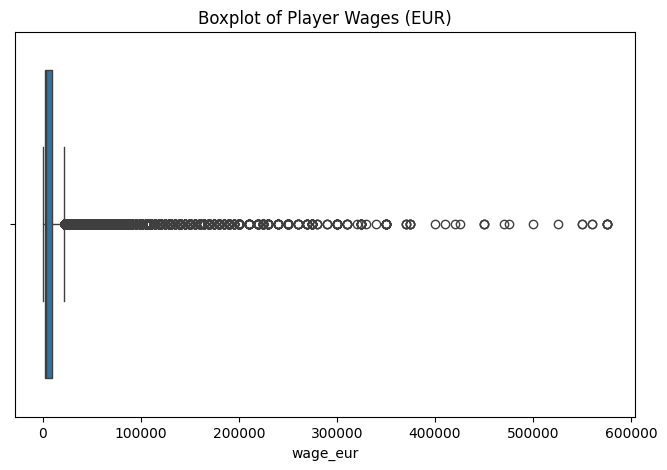


Suspected Outliers Count: 19143
Some Outliers: 
 0    550000.0
1    375000.0
2    275000.0
3    275000.0
4    300000.0
5    250000.0
6    300000.0
7    230000.0
8    200000.0
9    200000.0
Name: wage_eur, dtype: float64


In [3]:
# A2. Descriptive Statistics
wages =   df["wage_eur"].dropna() # dropping nil val's 

mean_val = wages.mean()
median_val = wages.median()
mode_val = wages.mode().tolist()
range_val = wages.max() - wages.min()
variance_val = wages.var()
std_val = wages.std()
iqr_val = wages.quantile(0.75) - wages.quantile(0.25)

print("\n=== A2. Descriptive Statistics ===")
print(f"Mean: {mean_val}")
print(f"Median: {median_val}")
print(f"Mode: {mode_val[:5]} ...") # first 5 mode
print(f"Range: {range_val}")
print(f"Variance: {variance_val}")
print(f"Standard Deviation: {std_val}")
print(f"IQR: {iqr_val}")

# boxplots
plt.figure(figsize=(8, 5))
sns.boxplot(x=wages, whis=1.5)
plt.title("Boxplot of Player Wages (EUR)")
plt.show()

# Outliers (using IQR method)
Q1 = wages.quantile(0.25)
Q3 = wages.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = wages[(wages < lower_bound) | (wages > upper_bound)]
print(f"\nSuspected Outliers Count: {len(outliers)}")
print("Some Outliers: \n", outliers.head(10))

In [5]:
# A3. Handling Missing Data
df_missing = df.copy() # for safety work with of df

# 5% wage droping
np.random.seed(42)
mask = np.random.rand(len(df_missing)) < 0.05
df_missing.loc[mask, "wage_eur"] = np.nan

print("Missing values in wage_eur:", df_missing["wage_eur"].isna().sum())


# (i) Constant Imputation
df_const = df_missing.copy()
df_const["wage_eur"] = df_const["wage_eur"].fillna(0) 

# (ii) Mean / Median / Mode 
df_mean = df_missing.copy()
mean_wage = df_mean["wage_eur"].mean()
df_mean["wage_eur"] = df_mean["wage_eur"].fillna(mean_wage)


df_median = df_missing.copy()
median_wage = df_median["wage_eur"].median()
df_median["wage_eur"] = df_median["wage_eur"].fillna(median_wage)

# (iii) Predictive Imputation
df_pred = df_missing.copy()

train = df_pred[df_pred["wage_eur"].notna()]
test = df_pred[df_pred["wage_eur"].isna()]

features = ["age", "overall", "potential"] # the basic rated desc
train_x = train[features]
train_y = train["wage_eur"]

model = LinearRegression()
model.fit(train_x, train_y)

# predict missing wages
pred_values = model.predict(test[features])
df_pred.loc[df_pred["wage_eur"].isna(), "wage_eur"] = pred_values



def compare_stats(original, imputed, name):
    print(f"\n{name} Imputation:")
    print(f"Mean: {imputed.mean():.2f} (Original: {original.mean():.2f})")
    print(f"Std: {imputed.std():.2f} (Original: {original.std():.2f})")

original_wages = df["wage_eur"].dropna()


compare_stats(original_wages, df_mean["wage_eur"], "Mean")
compare_stats(original_wages, df_median["wage_eur"], "Median")
compare_stats(original_wages, df_pred["wage_eur"], "Predictive")










Missing values in wage_eur: 9626

Mean Imputation:
Mean: 10841.48 (Original: 10855.41)
Std: 21261.15 (Original: 21941.66)

Median Imputation:
Mean: 10433.91 (Original: 10855.41)
Std: 21322.73 (Original: 21941.66)

Predictive Imputation:
Mean: 10875.60 (Original: 10855.41)
Std: 21519.22 (Original: 21941.66)


In [ ]:
# %% [markdown]
# # 📄 Report A (A1, A2, A3)
#
# ## A1. Data Types & Attributes  
# The FIFA dataset contains both numerical and categorical attributes:  
# - **Numerical (continuous/discrete):** `age`, `height_cm`, `weight_kg`, `wage_eur`, `overall`.  
# - **Categorical (nominal/ordinal):** `short_name`, `preferred_foot`, `work_rate`.  
# - *Discrete* variables (e.g., `age`, `player_id`) take only whole numbers.  
# - *Continuous* variables (`height_cm`, `wage_eur`) are measured on a ratio scale and can take any values.  
# - *Ordinal* variables (`overall`, `work_rate`) define an order but do not ensure equal intervals.  
#
# This shows the dataset has mixed data types and requires different preprocessing strategies.
#
# ---
#
# ## A2. Descriptive Statistics  
# For the **`wage_eur`** attribute (player wages):  
# - **Mean:** indicates the average salary but is highly sensitive to extreme outliers.  
# - **Median:** a more robust measure, as it is less influenced by top-star salaries.  
# - **Mode:** captures the most frequent salaries, typically low-wage ranges for majority players.  
# - **Range:** highlights the extreme spread between the lowest and highest salaries.  
# - **Variance & Standard Deviation:** confirm strong heterogeneity across players.  
# - **Interquartile Range (IQR):** focuses on the middle 50% of players, excluding extremes.  
#
# 📊 The **boxplot** revealed a right-skewed distribution with many outliers at the high end (superstar players).  
#
# **Conclusion:** player salaries are heavily right-skewed; most players earn relatively little, while a small group earns extremely high wages.
#
# ---
#
# ## A3. Handling Missing Data  
# To simulate missing values, ~5% of wages were set to `NaN`. Different imputation strategies were compared:
#
# 1. **Constant Imputation:** replaced missing wages with `0`.  
#    - Easy but unrealistic, introduces bias at the low end.  
#
# 2. **Mean/Median Imputation:**  
#    - Mean fills maintain the central tendency but are influenced by outliers.  
#    - Median is more robust and better for skewed distributions.  
#
# 3. **Predictive Imputation (Linear Regression):**  
#    - Used features `age`, `overall`, and `potential` to predict missing wages.  
#    - Produces more realistic estimates and preserves variance closer to the original distribution.  
#
# ### Comparison of imputations (vs. original data):
# - **Mean imputation:** shifted variance downward.  
# - **Median imputation:** more stable, less biased.  
# - **Predictive imputation:** best preserved the distribution and statistical properties.  
#
# ---
#
# ### 🔑 Key Takeaways
# - The dataset contains diverse attribute types requiring tailored preprocessing.  
# - Salary data is highly skewed, with strong inequality among players.  
# - For missing data, predictive imputation is preferable, while constant imputation should be avoided in real-world scenarios.  
